In [2]:

from qiskit import *
import matplotlib as mp
from qiskit.tools.visualization import plot_histogram
import numpy as np
from qiskit.circuit.library import MCXGate
from scipy.optimize import minimize
from qiskit.circuit.random import random_circuit

Alternate run

     ┌─────────┐┌──────┐┌───────────┐┌──────┐┌─────────┐┌──────┐┌───────────┐»
q_0: ┤ Rx(π/2) ├┤0     ├┤ Rx(5π/16) ├┤0     ├┤ Rx(π/2) ├┤0     ├┤ Rx(5π/16) ├»
     └─────────┘│      │└───────────┘│      │└─────────┘│      │└───────────┘»
q_1: ───────────┤1     ├─────────────┤1     ├───────────┤1     ├─────────────»
                │      │             │      │           │      │             »
q_2: ───────────┤2 Inc ├─────────────┤2 dec ├───────────┤2 Inc ├─────────────»
                │      │             │      │           │      │             »
q_3: ───────────┤3     ├─────────────┤3     ├───────────┤3     ├─────────────»
                │      │             │      │           │      │             »
q_4: ───────────┤4     ├─────────────┤4     ├───────────┤4     ├─────────────»
                └──────┘             └──────┘           └──────┘             »
c: 4/════════════════════════════════════════════════════════════════════════»
                                                    

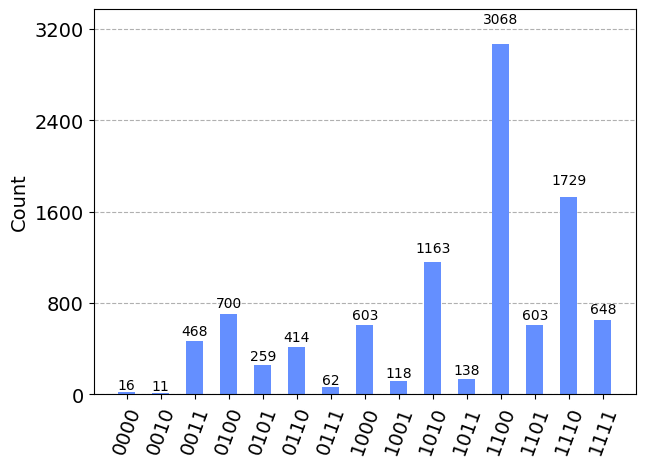

In [3]:
def increment_gate(n): # n = number of walking qubits
   qc = QuantumCircuit(n+1, name = "Inc")
   qc.cx(0,1)
   qc.ccx(0,1,2)
   for i in range(n+1):
      if (i > 2):
        qc.mcx([j for j in range(i)], i)


   return qc.to_gate()

def decrement_gate(n):
    qc = QuantumCircuit(n+1, name = "dec")

    for i in range(n, 0, -1):
      if (i > 1):
        qc.x([j for j in range(1,i)])
        qc.mcx([j for j in range(i)], i)
        qc.x([j for j in range(1,i)])
    qc.cx(0,1)

    return qc.to_gate()


theta_1 = np.pi/2
theta_2 = 5*np.pi/16

qwc = QuantumCircuit(5,4)
steps = 7
for i in range(steps):
  qwc.rx(theta_1, 0)
  qwc.append(increment_gate(4), [i for i in range(5)])
  qwc.rx(theta_2, 0)
  qwc.append(decrement_gate(4), [i for i in range(5)])
for i in range(4):
  qwc.measure(i+1,i)

print(qwc)
print(increment_gate)

simulator = Aer.get_backend('qasm_simulator')
result = execute(qwc, backend=simulator, shots = 10000).result() # changed shots to 10k, to see distri
counts = result.get_counts(qwc)
display(plot_histogram(counts))



Heights of each bin: [0.00149972 0.00557039 0.02056759 0.04177792 0.1034807  0.2121033
 0.31365579 0.40042532 0.39121275 0.31129909 0.18510833 0.09233992
 0.04349189 0.01456871 0.00449916 0.00085698]
[0.0007 0.0026 0.0096 0.0195 0.0483 0.099  0.1464 0.1869 0.1826 0.1453
 0.0864 0.0431 0.0203 0.0068 0.0021 0.0004]


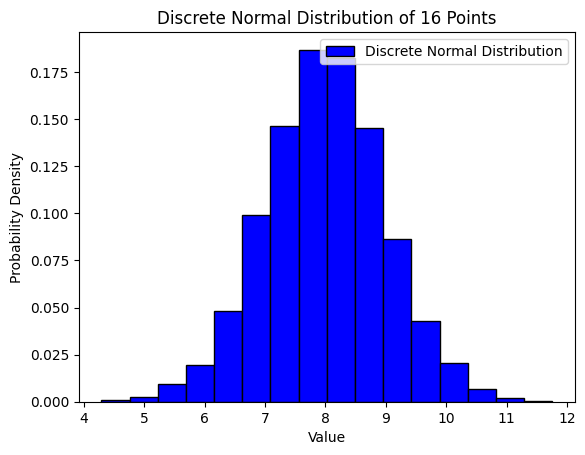

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Set the mean and standard deviation for the normal distribution
mean = 8
std_dev = 1

# Generate a large number of continuous random points
continuous_points = np.random.normal(loc=mean, scale=std_dev, size=10000)

# Discretize the points into a histogram with bins
hist, bins = np.histogram(continuous_points, bins=16, density=True)

# Calculate the bin centers
bin_centers = (bins[:-1] + bins[1:]) / 2

# Print the heights of each bin
print("Heights of each bin:", hist)
sum=np.sum(hist)
hist=hist/sum
print(hist)#shouldnt our target distri be normalized to 1?
# Plot the discrete normal distribution
plt.bar(bin_centers, hist, width=(bins[1] - bins[0]), color='blue', edgecolor='black', label='Discrete Normal Distribution')

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.title('Discrete Normal Distribution of 16 Points')

# Show the legend
plt.legend()

# Show the plot
plt.show()


In [5]:
import qiskit
qc_normal = QuantumCircuit(5,4)
def objective_function_normal(params): #using mse
  thetaa_1, thetaa_2 = params
  init_state = 8
  stepss = 7
  initial_state = bin(int(init_state) % 16)[2:].zfill(4)
  qc_normal.clear()
  qc_normal.prepare_state(initial_state, [i+1 for i in range(4)])
  for i in range(int(stepss)):
    qc_normal.rx(thetaa_1, 0)
    qc_normal.append(increment_gate(4), [i for i in range(5)])
    qc_normal.rx(thetaa_2, 0)
    qc_normal.append(decrement_gate(4), [i for i in range(5)])
  for i in range(4):
    qc_normal.measure(i+1,i)
  simulator = Aer.get_backend('qasm_simulator')
  result = execute(qwc, backend=simulator, shots = 1000).result() # changed shots to 10k, to see distri
  counts = result.get_counts(qwc)
  binary_dict = {format(i, '04b'): 0 for i in range(16)}
  for key in binary_dict.keys():
    if key in counts:
        binary_dict[key] = counts[key]
  probs = {outcome: count / 1000 for outcome, count in binary_dict.items()}
  list_of_probs = list(probs.values())
  #print(binary_dict)

  target_distri = hist
  return np.mean((np.array(target_distri) - np.array(list_of_probs))**2)



In [6]:
# running cobyla for optimization
initial_guess = [1.57,1.57]#initial guess pi/2,pi/2?
print(objective_function_normal(initial_guess))
from scipy.optimize import minimize
options = {'maxiter': 800000}

result = minimize(objective_function_normal, initial_guess,method='COBYLA', tol=1e-16,options=options )

0.012565902499999991


In [7]:
print(result.fun)
theta_1, theta_2 = result.x
print(theta_1)
print(theta_2)


0.012160764999999994
2.6085495758908377
1.8316119824021826


            ┌───────────────┐       ┌──────┐┌───────────────┐┌──────┐»
q_0: ───────┤ U(2.6085,0,0) ├───────┤0     ├┤ U(1.8316,0,0) ├┤0     ├»
     ┌──────┴───────────────┴──────┐│      │└───────────────┘│      │»
q_1: ┤0                            ├┤1     ├─────────────────┤1     ├»
     │                             ││      │                 │      │»
q_2: ┤1                            ├┤2 Inc ├─────────────────┤2 dec ├»
     │  State Preparation(0,0,0,0) ││      │                 │      │»
q_3: ┤2                            ├┤3     ├─────────────────┤3     ├»
     │                             ││      │                 │      │»
q_4: ┤3                            ├┤4     ├─────────────────┤4     ├»
     └─────────────────────────────┘└──────┘                 └──────┘»
c: 4/════════════════════════════════════════════════════════════════»
                                                                     »
«     ┌───────────────┐┌──────┐┌───────────────┐┌──────┐┌───────────────┐»
«q

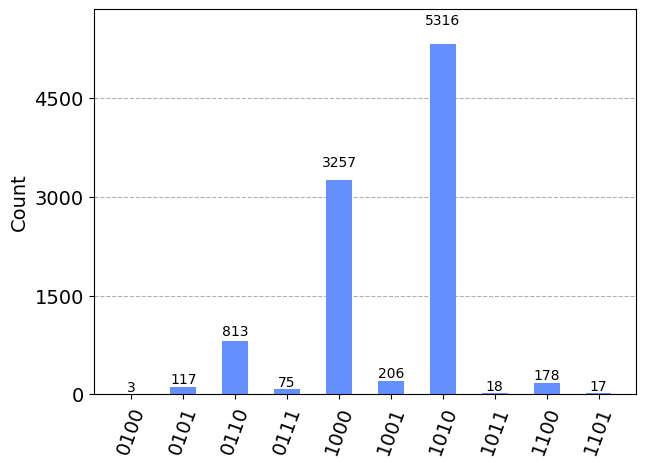

In [8]:


init_state = 0
initial_state = bin(int(init_state) % 16)[2:].zfill(4)
qwc = QuantumCircuit(5,4)
steps = 7
qwc.clear()
qwc.prepare_state(initial_state, [i+1 for i in range(4)])

for i in range(steps):
  qwc.u(theta_1, 0, 0, 0)
  qwc.append(increment_gate(4), [i for i in range(5)])
  qwc.u(theta_2, 0, 0, 0)
  qwc.append(decrement_gate(4), [i for i in range(5)])
for i in range(4):
  qwc.measure(i+1,i)

print(qwc)

simulator = Aer.get_backend('qasm_simulator')
result = execute(qwc, backend=simulator, shots = 10000).result() # changed shots to 10k, to see distri
counts = result.get_counts(qwc)
display(plot_histogram(counts))